In [2]:
#@@@@@@@@@@@@@@@@@@@@@@@
#import useful libraries
#@@@@@@@@@@@@@@@@@@@@@@@
import pandas as pd
import numpy as np
import copy
from scipy import interpolate
from scipy.stats import truncnorm
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from pydantic import BaseModel
import csv
import os
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Dict
import time

from game import TheGang
from models import HandFeatures

In [3]:
model_name = "Baseline_Deep"
model_epoch_count = 10000

In [4]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU


In [5]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer_size, hidden_layer_count = 1):
        super(PolicyNetwork, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_layer_size))
        nn.init.normal_(self.hidden_layers[0].weight, mean = 0, std = 0.01)
        nn.init.normal_(self.hidden_layers[0].bias, mean = 0, std = 0.01)
        for _ in range(hidden_layer_count-1):
            layer = nn.Linear(hidden_layer_size, hidden_layer_size)
            self.hidden_layers.append(layer)
            nn.init.normal_(layer.weight, mean = 0, std = 0.01)
            nn.init.normal_(layer.bias, mean = 0, std = 0.01)
        self.output_layer = nn.Linear(hidden_layer_size, 4)    #the output layer with probabiliy for each action
        self.output_layer.bias = nn.Parameter(torch.tensor([0.0, 0.0, 0.0, 0.0])) 

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        '''A function to do the forward pass
            Takes:
                s -- the state representation
            Returns:
                a tensor of probabilities
        '''         
        s = s.to(next(self.parameters()).device)
        for layer in self.hidden_layers:
             s = torch.relu(layer(s))    #pass through the hidden layers
        s = self.output_layer(s)
        action_probs = torch.softmax(s, dim=1)    #use softmax to get action probabilities
        return action_probs.to('cpu')


In [6]:
class AgentConfig(BaseModel):
    hidden_layer_size: int = 32
    hidden_layer_count: int = 8
    learning_rate: float = 0.0005

class Agent():
    def __init__(self, config: AgentConfig):
        self.config = config
        self.pi = PolicyNetwork(17, config.hidden_layer_size, config.hidden_layer_count).to(device)
        self.optimizer = optim.Adam(self.pi.parameters(), lr=self.config.learning_rate)

    def generate_actions(self, state_array: List[List[int]]):
        action_probs = self.pi(torch.tensor(state_array, dtype=torch.float32)) # Create tensor and feed state through model
        sampled_actions = torch.multinomial(action_probs, 1).squeeze(dim=1)
        action_space = torch.tensor([1, 2, 3, 4])
        final_actions = action_space[sampled_actions]
        return final_actions

    def generate_actions_with_probs(self, state_array: List[List[int]]):
        action_probs = self.pi(torch.tensor(state_array, dtype=torch.float32)) # Create tensor and feed state through model
        sampled_actions = torch.multinomial(action_probs, 1).squeeze(dim=1)
        action_space = torch.tensor([1, 2, 3, 4])
        final_actions = action_space[sampled_actions]
        return final_actions, action_probs

    def generate_action_probs(self, a: List[int], state_array: List[List[int]]):
        all_action_probs = self.pi(torch.tensor(state_array, dtype=torch.float32)) # Create tensor and feed state through model
        a_tensor = torch.tensor(a, dtype=torch.long)
        a_tensor = a_tensor - 1
        performed_action_probs = all_action_probs.gather(1, a_tensor.unsqueeze(1)).squeeze(1)
        log_probs = torch.log(performed_action_probs)
        return log_probs

    def checkpoint(self, model_name, epoch_count: int):
        directory = f'checkpoints/{model_name}'
        os.makedirs(directory, exist_ok=True)
        torch.save(self.pi.state_dict(), f'{directory}/epi_{epoch_count}.pth')
        
    def load_checkpoint(self, model_name: str, epoch_count: int):
        self.pi.load_state_dict(torch.load(f'checkpoints/{model_name}/epi_{epoch_count}.pth', map_location=device))


In [8]:
agent_config = AgentConfig(
    hidden_layer_count=32
)
agent = Agent(agent_config)
agent.load_checkpoint(model_name, model_epoch_count)
env = TheGang()

In [9]:
def simulate_agent(agent: Agent, episodes: int):
    env = TheGang()
    average_episode_rewards = []
    actions = []
    for epi in tqdm(range(episodes)):
        env.reset()

        episode_rewards = []
        episode_states = []
        episode_actions = []
        state = {'state':env.generate_state_array([0,0,0,0]),'reward':[0,0,0,0],'done':False}

        # Loop turns in episode
        while not state['done']:
            episode_states.append(state['state'])

            a = agent.generate_actions(state['state']).tolist()
            actions.append(a)

            episode_actions.append(a)
            state = env.step(a)
            episode_rewards.append(state['reward'])
        average_episode_rewards.append(np.mean(episode_rewards))
    return average_episode_rewards, actions

In [10]:
episode_rewards, actions = simulate_agent(agent, 1000)

100%|██████████| 1000/1000 [00:07<00:00, 134.06it/s]


In [11]:
np.mean(episode_rewards)

27.5

In [12]:
actions_list = np.array(actions).flatten()

In [13]:
action_space, action_counts = np.unique(actions_list, return_counts=True)

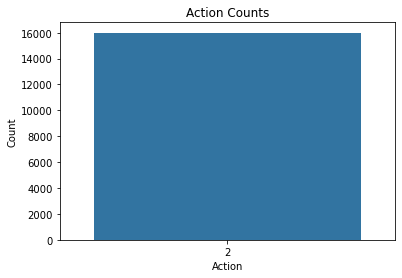

In [14]:
sns.barplot(x=action_space, y=action_counts)
plt.xlabel("Action")
plt.ylabel("Count")
plt.title("Action Counts")
plt.savefig(f"Action_Counts_{model_name}.svg", format="svg")

In [15]:
def simulate_agent(agent: Agent, episodes: int):
    env = TheGang()
    average_episode_rewards = []
    actions = []
    action_probs = []
    for epi in tqdm(range(episodes)):
        env.reset()

        episode_rewards = []
        episode_states = []
        episode_actions = []
        state = {'state':env.generate_state_array([0,0,0,0]),'reward':[0,0,0,0],'done':False}

        # Loop turns in episode
        while not state['done']:
            episode_states.append(state['state'])

            a, probs = agent.generate_actions_with_probs(state['state'])
            a = a.tolist()
            actions.append(a)
            action_probs.append(probs)

            episode_actions.append(a)
            state = env.step(a)
            episode_rewards.append(state['reward'])
        average_episode_rewards.append(np.mean(episode_rewards))
    return average_episode_rewards, actions, action_probs

In [ ]:
episode_rewards, actions, action_probs = simulate_agent(agent, 1000)

 54%|█████▎    | 535/1000 [00:03<00:03, 146.06it/s]

In [17]:
action_probs[1]

tensor([[1.9054e-28, 1.0000e+00, 5.3332e-10, 1.3085e-31],
        [1.9054e-28, 1.0000e+00, 5.3332e-10, 1.3085e-31],
        [1.9054e-28, 1.0000e+00, 5.3332e-10, 1.3085e-31],
        [1.9054e-28, 1.0000e+00, 5.3332e-10, 1.3085e-31]],
       grad_fn=<ToCopyBackward0>)

In [26]:
action_probs = [time_step_probs.tolist() for time_step_probs in action_probs]

AttributeError: 'list' object has no attribute 'tolist'

In [19]:
flat_list = []
for time_step_prob in action_probs:
    flat_list.extend(time_step_prob)

In [20]:
action_probs_df = pd.DataFrame(flat_list, columns=["1", "2", "3", "4"])

In [24]:
action_probs_df.head()

,1,2,3,4
0,1.905416e-28,1.0,5.333197e-10,1.308506e-31
1,1.905416e-28,1.0,5.333197e-10,1.308506e-31
2,1.905416e-28,1.0,5.333197e-10,1.308506e-31
3,1.905416e-28,1.0,5.333197e-10,1.308506e-31
4,1.905416e-28,1.0,5.333197e-10,1.308506e-31


In [25]:
sns.violinplot(action_probs_df, bw=0.05, cut=0)
plt.xlabel("Action")
plt.ylabel("Probability of Action")
plt.title("Probability Density of Actions")
plt.savefig(f"Action_Probability_Density_{model_name}.svg")

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().